In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

## Clustering MFCCs to predict Korean Phonemes

Current Result: Euclidean distance clustering **fails** to map to phonemes

See results at end of notebook

In [17]:
transcript_file = 'data/korean-single-speaker/transcript.v.1.4.txt'
tr_df = pd.read_csv(transcript_file, sep="|", names=["audio_file", "tr_w_num", "tr_syl", "tr_char", "dur", "en"])


In [18]:
# Since we are not interested in numerics as numbers, we drop that column
tr_df = tr_df.drop(columns=['tr_w_num'])
tr_df


,audio_file,tr_syl,tr_char,dur,en
0,1/1_0000.wav,그는 괜찮은 척하려고 애쓰는 것 같았다.,그는 괜찮은 척하려고 애쓰는 것 같았다.,3.5,He seemed to be pretending to be okay.
1,1/1_0001.wav,그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.,그녀의 사랑을 얻기 위해 애썼지만 헛수고ᄋ...,4.0,I tried in vain to win her love.
2,1/1_0002.wav,용돈을 아껴 써라.,용돈을 아껴 써라.,1.8,Save your pocket money.
3,1/1_0003.wav,그는 아내를 많이 아낀다.,그는 아내를 많이 아낀다.,2.3,He cherishes his wife.
4,1/1_0004.wav,그 애 전화번호 알아?,그 애 전화번호 알아?,1.3,Do you know his number?
...,...,...,...,...,...
12849,4/4_5627.wav,깨진 유리 조각에 손가락을 벴어요.,깨진 유리 조각에 손가락을 벴어요.,3.9,I cut my finger on a piece of broken glass.
12850,4/4_5628.wav,아드님이 친구들과 야구를 하다 유리창을 깼어요.,아드님이 친구들과 야구를 하다 유리창을 ᄁ...,5.4,Your son was playing baseball with his friends...
12851,4/4_5629.wav,일찍 신청하는 사람이 유리할 거야.,일찍 신청하는 사람이 유리할 거야.,3.7,Early applicants will be given advantages.
12852,4/4_5630.wav,이 두 소설은 줄거리가 유사해요.,이 두 소설은 줄거리가 유사해요.,3.5,These two novels are much alike in their synop...


Consonant Phonemes duration 25-50 msec
Vowel Phonemes duration 50-100+ msec


## Audio Analysis

In [19]:
# /kaggle/input/korean-single-speaker-speech-dataset/transcript.v.1.4.txt
# /kaggle/input/korean-single-speaker-speech-dataset/kss/1/1_0845.wav (example)

# from comet_ml import Experiment
import librosa
import librosa.display
from scipy.io import wavfile as wav
import IPython

In [20]:
data_dir = 'data/korean-single-speaker/kss'

sample_idxs = [0,4]
data_files = [tr_df['audio_file'][i] for i in sample_idxs]
sr_ = None
audio_ = None
for wv in data_files:
    fn = f'{data_dir}/{wv}'
    print(f'Data file to analyze: {fn}')
    print(f'current sample rate: {sr_}')
    new_audio_, new_sr_ = librosa.load(fn)
    print(f"latest sample rate: {new_sr_}")
    print(f'new_audio_ shape: {new_audio_.shape}')
    if sr_ is None:
        sr_ = new_sr_
    else:
        assert(new_sr_ == sr_)

    if audio_ is None:
        audio_ = new_audio_
    else:
        audio_ = np.concatenate((audio_, new_audio_))
    print('new audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(new_audio_), np.max(new_audio_)))
    print('full audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(audio_), np.max(audio_)))

print(f'final audio shape: {audio_.shape}')
tr_syl_ = tr_df['tr_syl'][sample_idxs]
print(f'text:')
print(f'{tr_syl_}')

Data file to analyze: data/korean-single-speaker/kss/1/1_0000.wav
current sample rate: None
latest sample rate: 22050
new_audio_ shape: (77760,)
new audio file min~max range: -0.98 to -0.98
full audio file min~max range: -0.98 to -0.98
Data file to analyze: data/korean-single-speaker/kss/1/1_0004.wav
current sample rate: 22050
latest sample rate: 22050
new_audio_ shape: (29371,)
new audio file min~max range: -0.91 to -0.91
full audio file min~max range: -0.98 to -0.98
final audio shape: (107131,)
text:
0    그는 괜찮은 척하려고 애쓰는 것 같았다.
4              그 애 전화번호 알아?
Name: tr_syl, dtype: object


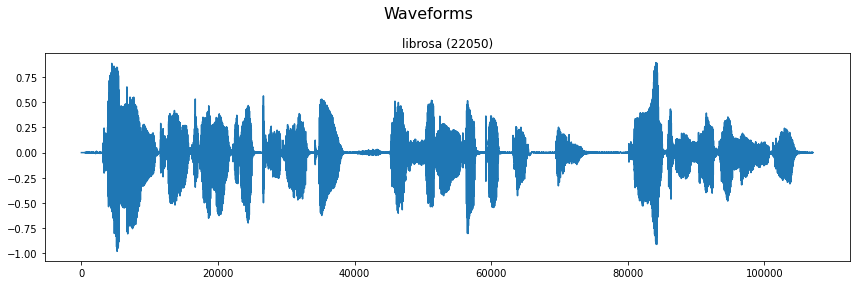

In [21]:
# fig, ax = plt.subplots()
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,4), tight_layout=True)
fig.suptitle('Waveforms', fontsize=16)
ax1.set_title(f'librosa ({sr_})')
ax1.plot(audio_)

### MFCCs

In [22]:
# n_fft = int(sr_ * 0.046)   # window length: 0.02 s
# print(n_fft)
# hop_length = n_fft // 2  # usually one specifies the hop length as a fraction of the window length
# print(hop_length)
# mfccs = librosa.feature.mfcc(audio_, sr=sr_, n_mfcc=40, hop_length=hop_length, n_fft=n_fft)
hop_length = 512
n_mfcc = 20

# n_mfcc might be useful as a hyper parameter
mfccs = librosa.feature.mfcc(y=audio_, sr=sr_, n_mfcc=n_mfcc, hop_length=hop_length)
print(mfccs.shape)

# num of mfcc frames(?) =~ num_samples/hop_length
print(audio_.shape)

(20, 210)
(107131,)


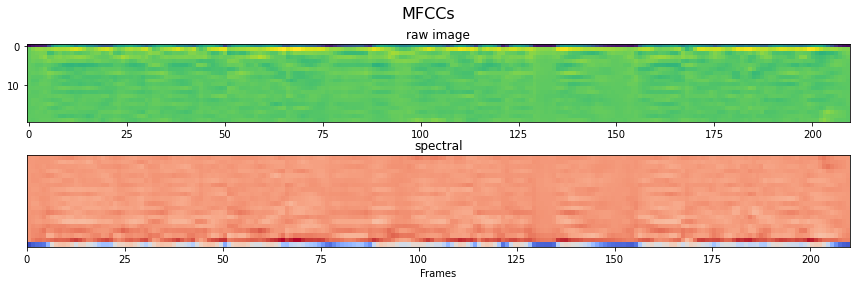

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,4), tight_layout=True)
fig.suptitle('MFCCs', fontsize=16)
ax1.set_title(f'raw image')
ax2.set_title(f'spectral')
ax1.imshow(mfccs)
librosa.display.specshow(mfccs, sr=sr_, x_axis='frames', ax=ax2)

### Onset Detection

What happens if we use onset detection to align the syllables?

In [24]:
# TODO: Understand hop_length in this context (we are using default so it aligns, but that's brittle)
# o_env = librosa.onset.onset_strength(y=librosa_audio, sr=librosa_sample_rate)
# times = librosa.times_like(o_env, sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
onset_detects = librosa.onset.onset_detect(y=audio_, sr=sr_, units='time')
print(onset_detects.shape)
print(onset_detects)

(20,)
[0.16253968 0.34829932 0.55727891 0.7662585  1.04489796 1.2306576
 1.43963719 1.60217687 1.85759637 2.08979592 2.32199546 2.55419501
 2.71673469 2.87927438 3.18113379 3.66875283 3.94739229 4.13315193
 4.43501134 4.66721088]


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


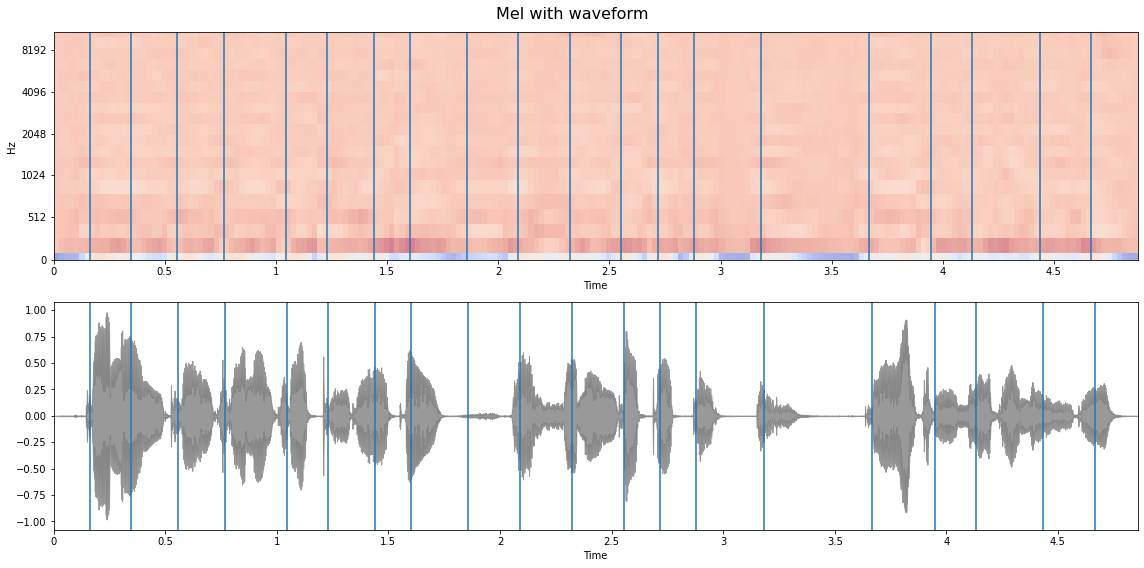

text: 0    그는 괜찮은 척하려고 애쓰는 것 같았다.
4              그 애 전화번호 알아?
Name: tr_syl, dtype: object


In [82]:
mfcc_cutoff = 20
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,8), tight_layout=True)
fig.suptitle('Mel with waveform', fontsize=16)
# ax2 = ax1.twinx()
librosa.display.specshow(mfccs[0:mfcc_cutoff], sr=sr_, x_axis='time', y_axis='mel', ax=ax1, alpha=0.5)
librosa.display.waveplot(audio_, sr=sr_, alpha=0.8, x_axis='time', ax=ax2, color='gray')

[ax1.axvline(x=x) for x in onset_detects]
[ax2.axvline(x=x) for x in onset_detects]
plt.show()
print(f'text: {tr_syl_}')



In [26]:
IPython.display.Audio(audio_, rate=sr_)

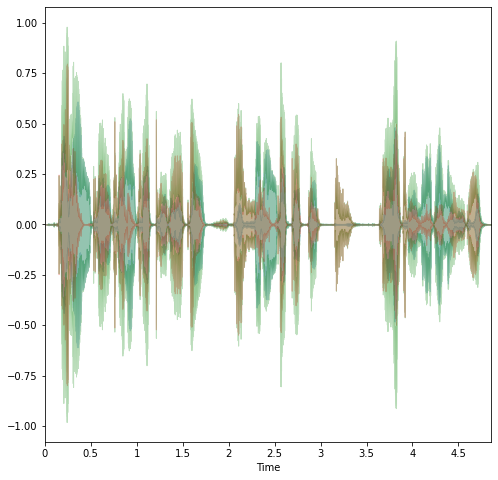

In [29]:
plt.figure(figsize=(8,8))
y_harm, y_perc = librosa.effects.hpss(audio_)
librosa.display.waveplot(y_harm, sr=sr_, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr_, color='r', alpha=0.25)
librosa.display.waveplot(audio_, sr=sr_, color='g', alpha=0.25)


In [31]:
from sklearn.cluster import KMeans

n_clusters = 5
audio_a = audio_.reshape(-1, 1)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.abs(audio_a))
print(kmeans.labels_.shape)

# find minimum audio value (quietest sample)
audio_min_idx = np.argmin(np.abs(audio_))
audio_min = audio_[audio_min_idx]

# find the cluster that sample is assigned to
silence_cluster = kmeans.labels_[audio_min_idx]


# Convert clusters to boolean
no_sig_tmp = np.array(kmeans.labels_== silence_cluster)
print(kmeans.labels_)

## Do not use the no_sig mask directly to the audio, it's only used to mark samples that should not be used
## However we still need additional processing on the no_sig to remove spurious no_sig markers as thay can happen
# if the signal has no power

## TODO: What does the power waveform look like? 

print(audio_a.shape)
print(fn)
print(sr_)



(107131,)
[3 3 3 ... 3 3 3]
(107131, 1)
data/korean-single-speaker/kss/1/1_0004.wav
22050


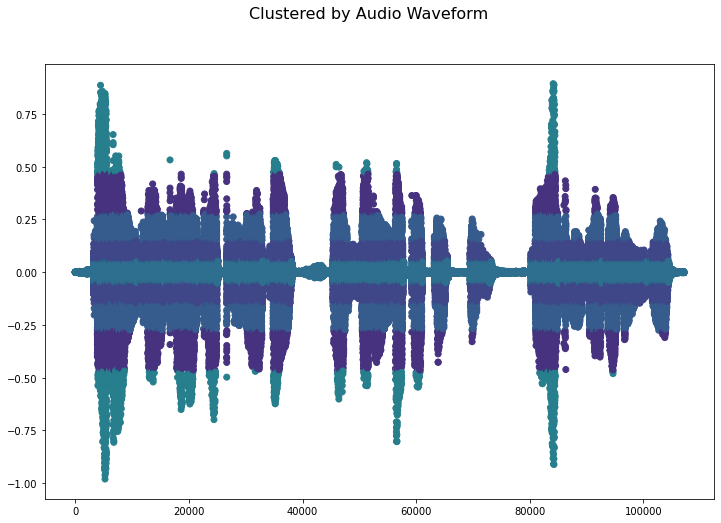

In [32]:
import matplotlib.cm as cm
from matplotlib import colors

cmap = cm.get_cmap('viridis', 15)
n_samps = kmeans.labels_.shape[0] # Not the best way, but should be ok
x_ = np.arange(n_samps)
c_ = kmeans.labels_
fig, ax1  = plt.subplots(figsize=(12,8))
fig.suptitle('Clustered by Audio Waveform', fontsize=16)
# librosa.display.waveplot(audio_, sr=sr_, alpha=0.25, x_axis='time', ax=ax1, color=colors[2])
# [ax1.axvline(x=x) for i,x in enumerate(kmeans.labels_)]
# ax1.scatter(x_, c_, c=cmap[c_]
ax1.scatter(x_, audio_a, c=cmap.colors[c_+2])
plt.show()

#### Convolve over hop_length

In [33]:
kernel = np.ones(hop_length)
# we divide by hop_length to keep relative values approximately the same
audio_pos = np.abs(audio_)
print(audio_pos.shape)
audio_sm = np.convolve(audio_pos, kernel, 'same')/hop_length
print(audio_sm.shape)

# TODO: We should be able to reduce the dimensionality.  Probably by hop_length/2 (so 2 bins for every hop_length)


(107131,)
(107131,)


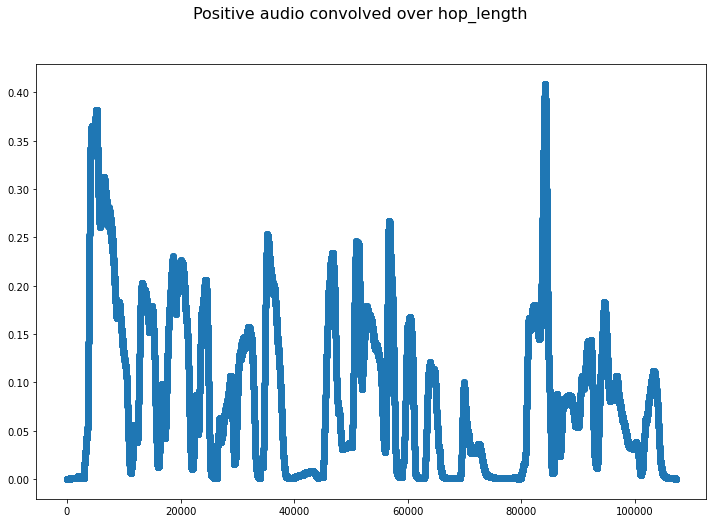

In [34]:
fig, ax1  = plt.subplots(figsize=(12,8))
fig.suptitle('Positive audio convolved over hop_length', fontsize=16)
ax1.scatter(x_, audio_sm)
plt.show()

(107131,)
512
210
389
(389,)
(107520,)
512
(210,)


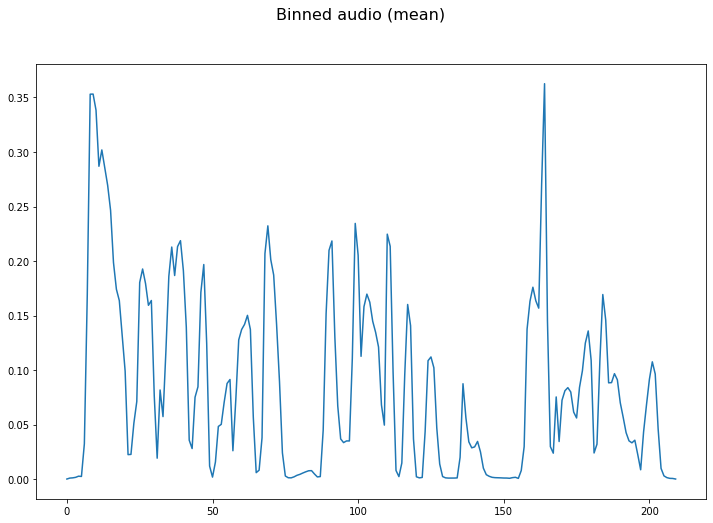

In [35]:
import math

audio_sm_len = audio_sm.shape[0]
n_bins = math.ceil(audio_sm_len/hop_length)
n_chunks = audio_sm_len/hop_length
pad_size = int((n_bins - n_chunks) * hop_length)
pad = np.zeros(pad_size)
audio_sm_pad = np.concatenate([audio_sm, pad])
samps_per_bin = audio_sm_pad.shape[0]//n_bins
audio_sm_reshape = audio_sm_pad.reshape((n_bins, samps_per_bin))
audio_sm_bin = np.mean(audio_sm_reshape, axis=1)


print(audio_sm.shape)
print(hop_length)
print(n_bins)
print(pad_size)
print(pad.shape)
print(audio_sm_pad.shape)
print(samps_per_bin)
print(audio_sm_bin.shape)

fig, ax1  = plt.subplots(figsize=(12,8))
fig.suptitle('Binned audio (mean)', fontsize=16)
ax1.plot(audio_sm_bin)
plt.show()



(107131,)


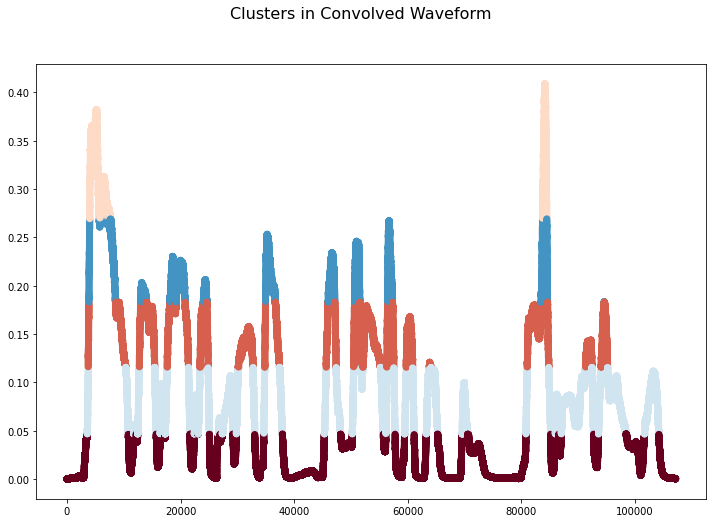

In [36]:
n_clusters = 5
audio_sm_a = audio_sm.reshape(-1, 1)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(audio_sm_a)
print(kmeans.labels_.shape)

cmap = cm.get_cmap('RdBu', 6)
colors = cmap(np.arange(0,cmap.N))
n_samps = kmeans.labels_.shape[0] # Not the best way, but should be ok
x_ = np.arange(n_samps)
c_ = kmeans.labels_
fig, ax1  = plt.subplots(figsize=(12,8))
fig.suptitle('Clusters in Convolved Waveform', fontsize=16)
# librosa.display.waveplot(audio_, sr=sr_, alpha=0.25, x_axis='time', ax=ax1, color=colors[2])
# [ax1.axvline(x=x) for i,x in enumerate(kmeans.labels_)]
# ax1.scatter(x_, c_, c=cmap[c_]
ax1.scatter(x_, audio_sm_a, c=colors[c_])
plt.show()

In [38]:
IPython.display.Audio(audio_sm, rate=sr_)

## Cluster MFCCs


In [39]:
# from sklearn.cluster import AffinityPropagation

mfccs_t = mfccs.T
print(mfccs_t[27])
mfcc_cl = KMeans(n_clusters=n_mfcc, random_state=0).fit(mfccs_t)
labels = mfcc_cl.labels_

[-122.44928      69.21655       9.871183     34.712486     -7.590722
  -52.917645    -25.376434     -2.322082    -14.269097    -13.886154
  -12.724991      8.723457    -15.282641      4.9156265   -12.220455
    5.912109    -12.218466    -10.312389      0.57208186  -15.212048  ]


No handles with labels found to put in legend.


(210, 20)
[ 5  5  5  5  5 16  2  2 14 14 14 14  6 14 14 11 11  6  4  4  4  4 11  2
 15 14 14 14  6  6  4  0 19 19  2  2  2 14  6  6  6  6  4  0 19 19  2 18
  8  8 10  7  2  2  2  2  2 15 15 15 15 14  8  8 17 10 10 17 17 17 17 17
 10 10 10 10  1  5  9  9 16 16 16 16 16 16  9  9  4 14 14 14 15 12 12 12
 12 12 12 11  6  6  6  6 11 11  4  4  3  8  8  8  8  3  9 11  2 14 14  6
  4  5  9  6  2  2  2 15  4  5  5  5  5  5  5  4 13 13 13 13 13 13  7  7
  7  9  1  1  1  5  5  5  5  5  5  1  7  6  6 11 11 11 11 11 11 14 11  0
 19 19  2  8  8  3  3  4  3  6  6  8  8 17  3 17 17 17  3  4  4  6  6 18
 13 13 13 13 13  4  6  8 18 18 18 18  7  7  1  1  5  5]
text: 0    그는 괜찮은 척하려고 애쓰는 것 같았다.
4              그 애 전화번호 알아?
Name: tr_syl, dtype: object


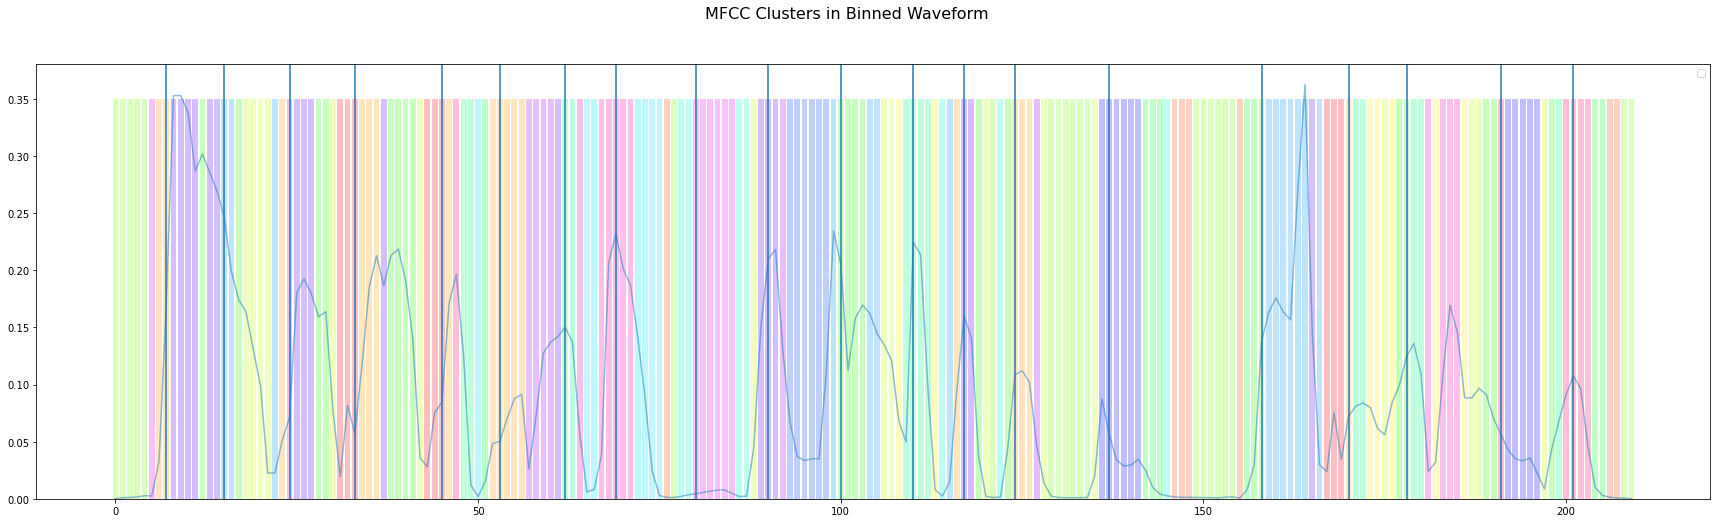

In [63]:
print(mfccs_t.shape)
print(labels)

cmap = cm.get_cmap('hsv', max(mfcc_cl.labels_)+1)
cl_label = np.arange(0, cmap.N)
colors = cmap(cl_label)
n_samps = mfcc_cl.labels_.shape[0] # Not the best way, but should be ok
x_ = np.arange(n_samps)
c_ = mfcc_cl.labels_
fig, ax1  = plt.subplots(figsize=(30,8))
fig.suptitle('MFCC Clusters in Binned Waveform', fontsize=16)
# librosa.display.waveplot(audio_, sr=sr_, alpha=0.25, x_axis='time', ax=ax1, color=colors[2])
# [ax1.axvline(x=x) for i,x in enumerate(kmeans.labels_)]
# ax1.scatter(x_, c_, c=cmap[c_]

# ax1.scatter(x_, audio_sm_bin, c=colors[c_])
ax1.bar(x_,np.ones(n_bins)*0.35, color=colors[c_], alpha=0.25)
ax1.plot(audio_sm_bin, alpha=0.5)
ax1.legend()
[ax1.axvline(x=x*(sr_/hop_length)) for x in onset_detects]
plt.show()


print(f'text: {tr_syl_}')
IPython.display.Audio(audio_, rate=sr_)